Datasets have been cleaned and transferred to fresh csv files

We will import them and commence our analyses

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import folium
from folium import plugins
from folium.plugins import MarkerCluster
import dash
from dash import html, dcc, Input, Output, callback
import dash_leaflet as dl
import re
import shapely
from shapely import Point
import geopandas as gpd

In [3]:
#import the datasets
weather_data = pd.read_csv("weather.csv")
geospatial_data = pd.read_csv("geospatial.csv")
ev_distribution_data = pd.read_csv("ev_distribution.csv")

In [4]:
#wrangle ev_distribution_data a little more to remove duplicates and convert KW to MW, also to seperate the Timestamp
ev_distribution_data.drop(columns="Unnamed: 0",inplace=True)
ev1_dist_data = ev_distribution_data.drop_duplicates(ignore_index = True)

In [5]:
ev1_dist_data['Timestamp'] = pd.to_datetime(ev1_dist_data['Timestamp'])
ev1_dist_data['month'] = ev1_dist_data['Timestamp'].dt.month_name()
ev1_dist_data['day'] = ev1_dist_data['Timestamp'].dt.day_name()
ev1_dist_data['hour'] = ev1_dist_data['Timestamp'].dt.hour

In [6]:
#Convert Electricity consumption from KWh to MWh
#1KW = 0.001MW
ev1_dist_data['Electricity_Consumption (kWh)'] = ev1_dist_data['Electricity_Consumption (kWh)'] * 0.001
ev1_dist_data.rename(columns = {'Electricity_Consumption (kWh)' : 'Electricity_Consumption (MWh)'}, inplace = True)

                                    N E T W O R K  C A P A C I T Y  A N A L Y S I S

In [7]:
#TOTAL CONSUMPTION IN TWO MONTHS
ev1_dist_data['Electricity_Consumption (MWh)'].sum()

49.67824363644012

In [8]:
#TOTAL TRANSMISSION CAPACITY 
total_transmission_cap = geospatial_data["Transmission_Line_Capacity (MW)"].sum()
total_transmission_cap

2637

AVERAGE HOURLY ENERGY CONSUMPTION

***Data was gathered at random hours, giving a sample size of 97 rows, interpreted as 97 different hours out of two months with a total energy consumption of 49.68MWH

In [9]:
#What is the average energy consumption per hour
avg_energy_cons_per_hour = ev1_dist_data['Electricity_Consumption (MWh)'].mean()
avg_energy_cons_per_hour

0.5121468416127848

If we know the average energy consumed per hour, how much, on average, is consumed per day

In [10]:
#average consumption in 24 hours
avg_energy_cons_per_day = avg_energy_cons_per_hour *24
print("The average daily energy consumption is {}".format(avg_energy_cons_per_day))

The average daily energy consumption is 12.291524198706835


So far we have gathered that the company has a total capacity of 2637megawatts and an average hourly consumption of 0.5megawatts/h equalling an average of 12mwh in 24 hours/1day. 

HOW MANY POSSIBLE VEHICLES ARE SERVICED IN A DAY GIVEN THE AVERAGE

AVERAGE OF VEHICLES SERVICED IN AN HOUR

In [11]:
ev_avg_number = ev1_dist_data['Number_of_EVs'].mean()
ev_avg_number

5.247422680412371

AVERAGE VEHICLES FOR A DAY

In [12]:
ev_avg_daily_number = ev_avg_number * 24
ev_avg_daily_number

125.93814432989691

Therefore, we average of 126 vehicles and 12mw of energy consumed in a day. Our capacity being 2637mw in total

If on average it takes 126 vehicles to make an average of 12mw per day, then how many vehicles will exhaust our capacity?

In [13]:
#HOW MANY VEHICLES WILL IT TAKE TO EXHAUST OUR CAPACITY
(total_transmission_cap * ev_avg_daily_number)/avg_energy_cons_per_day

27018.527664199493

For the company's capacity:

Currently, at 2,637MW capacity, we have an average of 126 vehicles charging per day, and an average of 12MW being consumed per day.

It will take an average of 27,018 vehicles per day for our capacity to be exhausted.
Given the rate of adoption of electric vehicles, 27018 vehicles for service per day is still possible but we are good for now.

                BIVARIATE ANALYSIS - ANALYSING VARIABLES' RELATIONSHIP TO ENERGY CONSUMPTION

In [14]:
#we will merge weather and ev_distribution data
weather_data['Timestamp'] = pd.to_datetime(weather_data['Timestamp'])
weather_evdist_data = pd.merge(ev1_dist_data, weather_data)
weather_evdist_data.drop(columns="Unnamed: 0", axis=1, inplace=True)

In [15]:
#join geospatial data to weather_evdist data.
geospatial_data.drop('Unnamed: 0', axis=1, inplace=True)
geo_weather_evdist_data = pd.merge(geospatial_data, weather_evdist_data, on = 'Substation_ID' )

In [16]:
#Seperate the latitudes and longitudes for both substation and ev_charging_locations.
substation_latitude = []
substation_longitude = []
for loc in geo_weather_evdist_data['Substation_Location'].values:
    lat = re.search(r'[0-9]*\.[0-9]*', loc).group()
    long = re.search(r'(?<=, )(-*)[0-9]*\.[0-9]*', loc).group()
    lat = pd.to_numeric(lat)
    long = pd.to_numeric(long)
    substation_latitude.append(lat)
    substation_longitude.append(long)

In [17]:
#Seperate the latitudes and longitudes for both substation and ev_charging_locations.
ev_location_latitude = []
ev_location_longitude = []
for loc in geo_weather_evdist_data['EV_Charging_Station_Location'].values:
    lat = re.search(r'[0-9]*\.[0-9]*', loc).group()
    long = re.search(r'(?<=, )(-*)[0-9]*\.[0-9]*', loc).group()
    lat = pd.to_numeric(lat)
    long = pd.to_numeric(long)
    ev_location_latitude.append(lat)
    ev_location_longitude.append(long)

In [18]:
#Then concat them all into one dataframe
substation_latitude  = pd.DataFrame(substation_latitude)
substation_longitude = pd.DataFrame(substation_longitude)
ev_location_latitude = pd.DataFrame(ev_location_latitude)
ev_location_longitude = pd.DataFrame(ev_location_longitude)
latlonglocations = pd.concat([substation_latitude, substation_longitude, ev_location_latitude, ev_location_longitude], axis = 1)
latlongheaders = ['substation_latitude', 'substation_longitude', 'ev_location_latitude', 'ev_location_longitude']
latlonglocations.columns = latlongheaders

In [19]:
#concat latlonlocations dataframe with geoweatherevdist dataframe so we have just one data frame containing all variables
geo_weather_evdist_data = pd.concat([geo_weather_evdist_data, latlonglocations], axis = 1)
#drop the tuple of strings containing the coordinate points of substation and ev_chargingLocations as we now have seperate columns for them
geo_weather_evdist_data = geo_weather_evdist_data.drop(['Substation_Location', 'EV_Charging_Station_Location'], axis = 1)
geo_weather_evdist_data

,Substation_ID,Transmission_Line_Capacity (MW),Timestamp,Geographical_Area,Customer_Type,Electricity_Consumption (MWh),EV_Charging_Station_Specifications,EV_Type,Charging_Habit,Number_of_EVs,...,day,hour,Temperature (°C),Precipitation (mm),Weather_Conditions,year,substation_latitude,substation_longitude,ev_location_latitude,ev_location_longitude
0,Substation_907,40,2020-01-10 18:00:00,Urban,Industrial,0.714394,Type 2,Electric Car,Occasional,8,...,Friday,18,17.726056,2.938451,Rainy,2020,57.258136,-70.905820,64.019436,-129.531964
1,Substation_907,40,2020-01-22 17:00:00,Rural,Residential,0.554336,Type 2,Electric Scooter,Weekly,5,...,Wednesday,17,31.150853,4.032014,Clear,2020,57.258136,-70.905820,48.447827,-71.988591
2,Substation_218,71,2020-01-31 17:00:00,Suburban,Commercial,0.598269,Type 2,Electric Scooter,Weekly,9,...,Friday,17,26.170457,4.935412,Clear,2020,70.025385,-84.380572,39.685331,-79.058662
3,Substation_218,71,2020-02-03 22:00:00,Rural,Industrial,0.603184,Type 2,Electric Scooter,Daily,2,...,Monday,22,22.508444,4.362870,Snowy,2020,70.025385,-84.380572,71.128352,-112.204478
4,Substation_339,85,2020-01-17 10:00:00,Rural,Residential,0.617944,Type 1,Electric Scooter,Daily,5,...,Friday,10,18.710718,2.438594,Snowy,2020,80.393235,-75.797841,31.715555,-83.488746
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,Substation_64,26,2020-02-06 06:00:00,Urban,Commercial,0.482305,DC Fast,Electric Car,Occasional,1,...,Thursday,6,26.253258,3.729321,Clear,2020,76.889055,-82.649057,61.175469,-108.507749
95,Substation_208,84,2020-01-26 01:00:00,Suburban,Commercial,0.407783,Type 2,Electric Car,Weekly,7,...,Sunday,1,27.164223,0.435410,Clear,2020,59.717237,-117.352601,35.295295,-100.596812
96,Substation_952,25,2020-01-19 07:00:00,Urban,Commercial,0.494445,Type 2,Electric Scooter,Daily,3,...,Sunday,7,29.429512,3.255885,Rainy,2020,70.416162,-83.367592,29.185202,-97.996928
97,Substation_470,52,2020-01-15 12:00:00,Urban,Residential,0.428156,Type 2,Electric Scooter,Occasional,8,...,Wednesday,12,15.264423,1.284959,Clear,2020,37.441719,-82.573649,21.013013,-89.330010


                                    COMPARE THE GEOGRAPHICAL AREA WITH CONSUMPTION

<Axes: xlabel='Geographical_Area', ylabel='Electricity_Consumption (MWh)'>

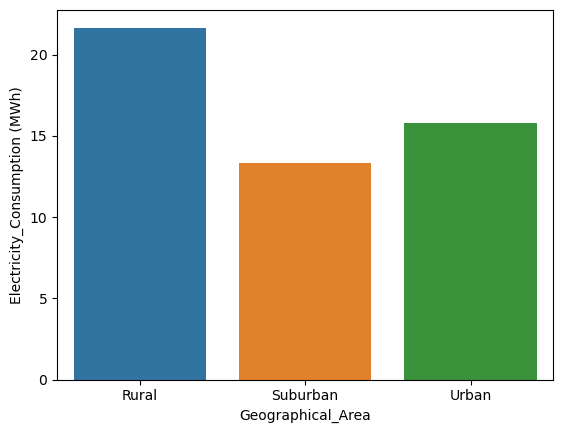

In [20]:
#group the column
geo_area = geo_weather_evdist_data[['Geographical_Area', 'Electricity_Consumption (MWh)']]
geo_area_grouped = geo_area.groupby(['Geographical_Area'], as_index=False).sum()
sns.barplot(data=geo_area_grouped, x = 'Geographical_Area', y = 'Electricity_Consumption (MWh)')

Rural consumes more energy while suburban consumes the least

Therefore rural areas are to be considered in the distribution of substations with capacities to accommodate their consumption level

                                            ANALYZE CUSTOMER TYPE AND CONSUMPTION

<Axes: xlabel='Customer_Type', ylabel='Electricity_Consumption (MWh)'>

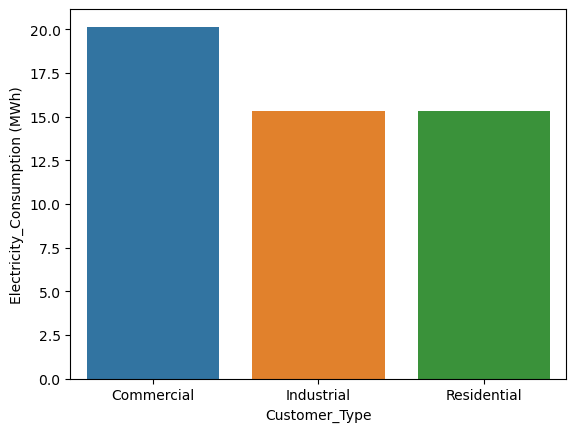

In [21]:
#group the column
cust_type = geo_weather_evdist_data[['Customer_Type', 'Electricity_Consumption (MWh)']]
cust_type_grouped = cust_type.groupby(['Customer_Type'], as_index=False).sum()
sns.barplot(data=cust_type_grouped, x = 'Customer_Type', y = 'Electricity_Consumption (MWh)')

Commercial customers consume the most energy

                                ANALYZE EV_CHARGING_STATION_SPECIFICATIONS WITH CONSUMPTION

<Axes: xlabel='EV_Charging_Station_Specifications', ylabel='Electricity_Consumption (MWh)'>

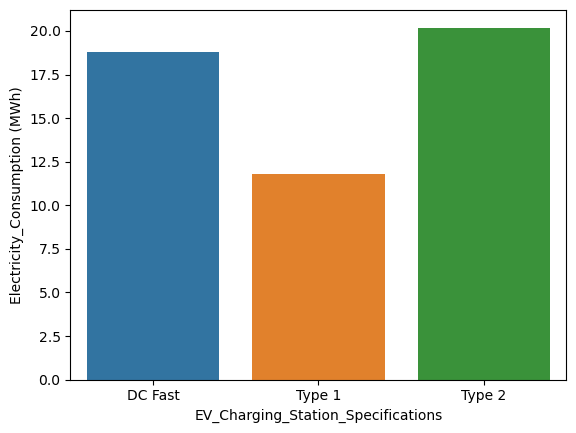

In [22]:
#group the column
station_spec = geo_weather_evdist_data[['EV_Charging_Station_Specifications', 'Electricity_Consumption (MWh)']]
station_spec_grouped = station_spec.groupby(['EV_Charging_Station_Specifications'], as_index=False).sum()
sns.barplot(data=station_spec_grouped, x = 'EV_Charging_Station_Specifications', y = 'Electricity_Consumption (MWh)')

Type 1 consumes the least energy, while Type 2 consumes the most, followed by DC-Fast

                                                ANALYZE EV_TYPE AND CONSUMPTION

<Axes: xlabel='EV_Type', ylabel='Electricity_Consumption (MWh)'>

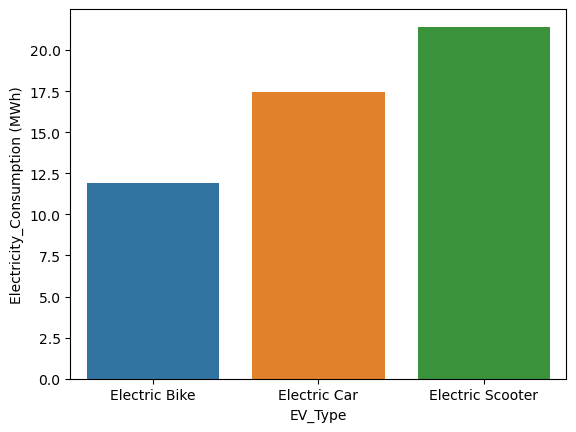

In [23]:
#group the column
ev_type = geo_weather_evdist_data[['EV_Type', 'Electricity_Consumption (MWh)']]
ev_type_grouped = ev_type.groupby(['EV_Type'], as_index=False).sum()
sns.barplot(data=ev_type_grouped, x = 'EV_Type', y = 'Electricity_Consumption (MWh)')

The scooter consumes the most energy while the bike consumes the least

                                    ANALYZING CHARGING HABIT AND CONSUMPTION

<Axes: xlabel='Charging_Habit', ylabel='Electricity_Consumption (MWh)'>

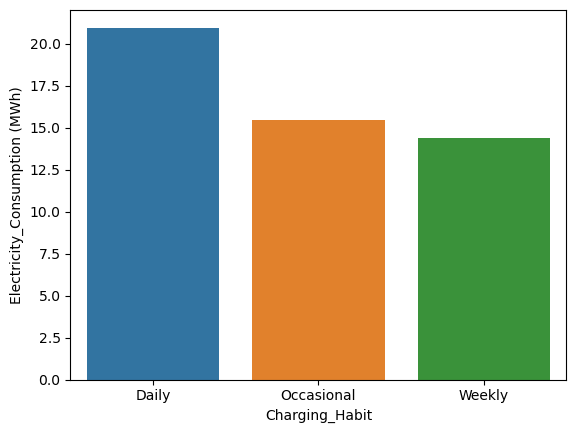

In [24]:
#group the column
charging_habit = geo_weather_evdist_data[['Charging_Habit', 'Electricity_Consumption (MWh)']]
charging_habit_grouped = charging_habit.groupby(['Charging_Habit'], as_index=False).sum()
sns.barplot(data=charging_habit_grouped, x = 'Charging_Habit', y = 'Electricity_Consumption (MWh)')

Daily consumers obviously consume the most energy, while weekly consumers surprisingly consume the least

                                        ANALYZE TIME OF THE DAY MOST USED

    First, we divide them into bins

In [25]:
hour_cuts = np.linspace(geo_weather_evdist_data['hour'].min(), geo_weather_evdist_data['hour'].max(), num = 5, endpoint=True )
hour_times = ["early-morn", "morning", "afternoon", "night"]
hour_groups = pd.cut(geo_weather_evdist_data['hour'], bins = hour_cuts, labels=hour_times, include_lowest=True)
geo_weather_evdist_data['time_of_day'] = hour_groups

<Axes: xlabel='time_of_day', ylabel='Electricity_Consumption (MWh)'>

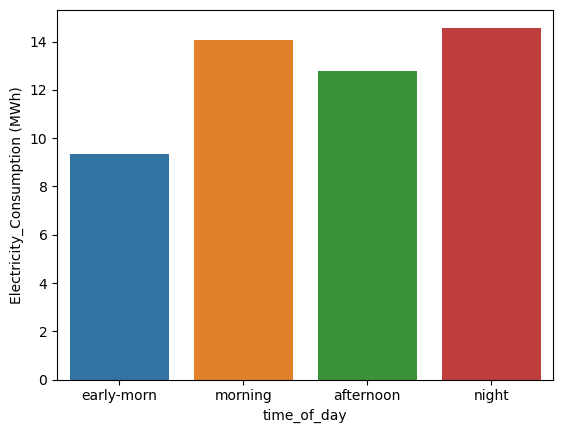

In [26]:
#group the column
times_of_day = geo_weather_evdist_data[['time_of_day', 'Electricity_Consumption (MWh)']]
times_of_day_grouped = times_of_day.groupby(['time_of_day'], as_index=False).sum()

sns.barplot(data= times_of_day_grouped, x="time_of_day", y="Electricity_Consumption (MWh)")

Energy is consumed more in the morning and night, and least in the early-mornings

                                        ANALYZE TEMPERATURE CONDITIONS AND ENERGY CONSUMPTION

    First, we divide into two bins - hot and cold

In [27]:
temp_types = np.linspace(0, 50, num = 3)
temp_groups = ['cold', 'hot']
temperature_types = pd.cut(geo_weather_evdist_data['Temperature (°C)'], bins = temp_types, labels = temp_groups)
geo_weather_evdist_data['Temperature_types'] = temperature_types

<Axes: xlabel='Temperature_types', ylabel='Electricity_Consumption (MWh)'>

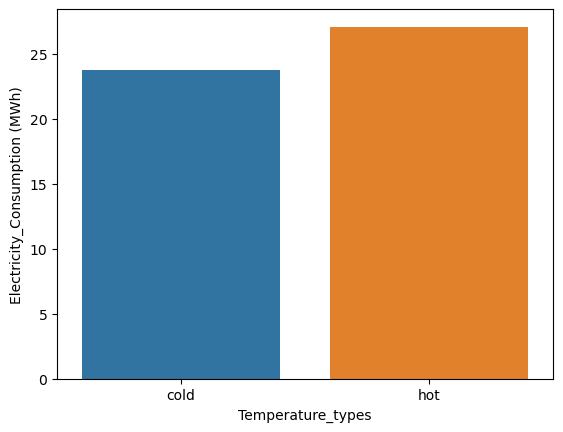

In [28]:
#group columns
temp_consum = geo_weather_evdist_data[['Temperature_types', 'Electricity_Consumption (MWh)']]
temp_consum_grouped = temp_consum.groupby(['Temperature_types'], as_index = False).sum()
sns.barplot(data=temp_consum_grouped, x='Temperature_types', y='Electricity_Consumption (MWh)')

Energy is consumed more in the hot weather

<Axes: xlabel='Temperature (°C)', ylabel='Electricity_Consumption (MWh)'>

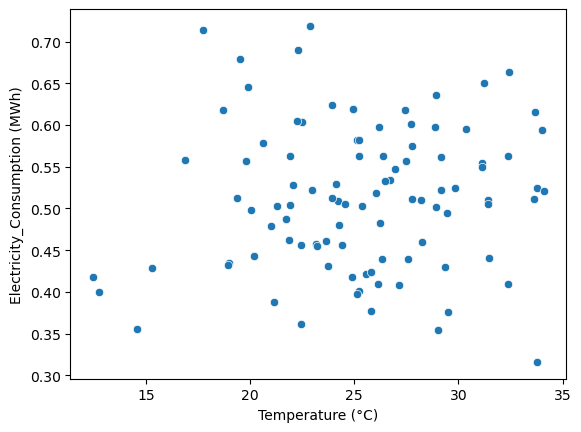

In [29]:
#confirming the correlation between temperature and consumption
sns.scatterplot(data=geo_weather_evdist_data, x='Temperature (°C)', y='Electricity_Consumption (MWh)')

There is however no correlation between temperature and consumption

                            ANALYZE NUMBER OF ELECTRIC VEHICLES AND CONSUMPTION

<Axes: xlabel='Number_of_EVs', ylabel='Electricity_Consumption (MWh)'>

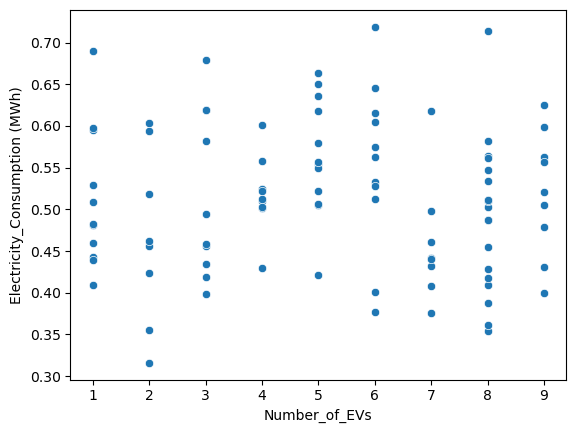

In [30]:
sns.scatterplot(data=geo_weather_evdist_data, x='Number_of_EVs', y='Electricity_Consumption (MWh)')

There is no correlation between number of Evs and consumption

                                    ANALYZE WEATHER CONDITION AND CONSUMPTION

<Axes: xlabel='Weather_Conditions', ylabel='Electricity_Consumption (MWh)'>

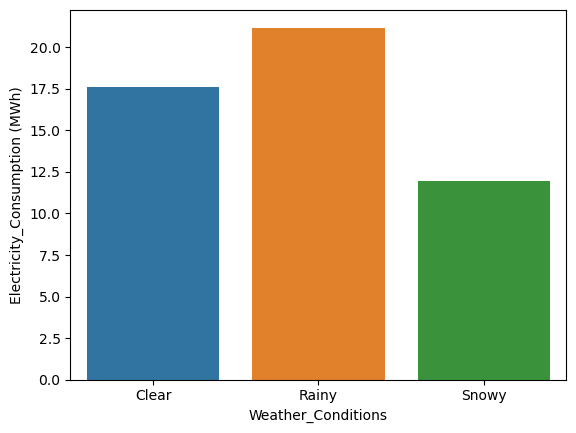

In [31]:
weather_cons = geo_weather_evdist_data[['Weather_Conditions', 'Electricity_Consumption (MWh)']]
weather_cons_grouped = weather_cons.groupby(['Weather_Conditions'], as_index = False).sum()
sns.barplot(data= weather_cons_grouped, x= 'Weather_Conditions', y = 'Electricity_Consumption (MWh)')

Energy is consumed more during rainy seasons

                                            ANALYZE MONTH AND CONSUMPTION

In [32]:

month_energy = geo_weather_evdist_data[['month', 'Electricity_Consumption (MWh)' ]]
month_energy_grouped = month_energy.groupby(['month'], as_index=False).sum()

<Axes: xlabel='month', ylabel='Electricity_Consumption (MWh)'>

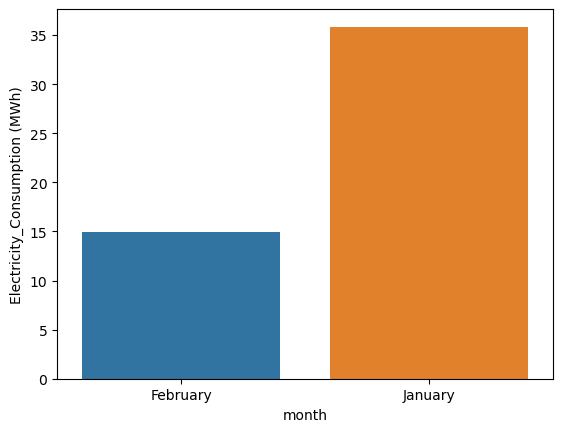

In [33]:
sns.barplot(data=month_energy_grouped, x='month', y='Electricity_Consumption (MWh)')

Energy was consumed less in February which calls for scrutiny

How many entries were entered for February?


In [34]:
feb_data = geo_weather_evdist_data[geo_weather_evdist_data['month']=='February']
feb_data.shape

(29, 23)

29 rows out of 99 rows. This is most likely the reason.

                                    I D E N T I F Y I N G    -   B O T T L E N E C K S

1. DISTANCE BETWEEN SUBSTATIONS AND THEIR RESPECTIVE EV LOCATIONS

In [35]:
#Creating a dashboard that allows for interactivity to show the distance betweeen each substations and their respective ev_charging_stations.

In [36]:
#initialize the map
mapthis = folium.Map()
mapthischild = folium.map.FeatureGroup()
mapthis.save('evlocation_maphtml.html')

In [37]:
substationdata = geo_weather_evdist_data[['Substation_ID']]
substationdataunique = substationdata.drop_duplicates().reset_index()
substationdataunique = substationdataunique.drop('index', axis = 1)

In [38]:
#create the layout
app = dash.Dash()
app.layout = html.Div([html.H1('DISTANCE BETWEEN SUBLOCATIONS AND THEIR RESPECTIVE EV_CHARGING LOCATIONS', style={'textAlign':'center', 'color':'black'}),
                       html.Label('Choose a sub_station', style={'color':'red'}),
                       dcc.Dropdown(id = 'input-station', options = [i for i in list(substationdataunique['Substation_ID'])], value = 'Substation_208', searchable=True),
                       html.P('Hover the pointer on the markes and lines for description', style={'color':'blue'}),
                      html.Div(html.Iframe(id='folium-map', srcDoc = open('evlocation_maphtml.html', 'r').read(), style={'width':'100%', 'height': 500})),
                      
                      ])


#create the callback function for each selected substation_ID
@app.callback (Output('folium-map', 'srcDoc'),
              [Input('input-station', 'value')])

def update_graph(chosen_station):
    txt = 'argument accepted'
    mapthis = folium.Map(location=[54.5260, -105.2551], zoom_start=3)
    mapthischild = folium.map.FeatureGroup()
    subloc_group1 = geo_weather_evdist_data[geo_weather_evdist_data['Substation_ID']==chosen_station]
    mapthischild.add_child(folium.features.CircleMarker(location = [subloc_group1['substation_latitude'].tolist()[0], subloc_group1['substation_longitude'].tolist()[0]],
                                                              radius = 10,
                                                              color = 'blue', fill = True, fill_color = 'blue', fill_opacity=1,
                                                              tooltip= '{}'.format(subloc_group1['Substation_ID'].tolist()[0])))
    for lat, long in zip(subloc_group1['ev_location_latitude'], subloc_group1['ev_location_longitude']):
        mapthischild.add_child(folium.features.CircleMarker(location = [lat, long],
                                                              radius = 10,
                                                              color = 'yellow', fill = True, fill_color = 'yellow', fill_opacity=1,
                                                              tooltip = 'ev_locations for {}'.format(subloc_group1['Substation_ID'].tolist()[0])))
        new_frame = [[subloc_group1['substation_latitude'].tolist()[0], subloc_group1['substation_longitude'].tolist()[0]], [lat, long]]
        folium.PolyLine(locations=new_frame, color='red', tooltip='distance between {} and its ev_locations'.format(subloc_group1['Substation_ID'].tolist()[0])).add_to(mapthis)
    evlocation_file = mapthis.add_child(mapthischild)
    evlocation_file.save('evlocation_maphtml.html')
    return open('evlocation_maphtml.html', 'r').read(), txt

In [39]:
app.run()

From the map, we see that the substations transmit energy to some locations very distant from them which they can easily transmit energy. This increases transmission loss. That is bottleneck number 1

2 - SUBSTATION CAPACITY AND ENERGY CONSUMPTION. ANALYZING SUBSTATION CAPACITY AND THE CHARGINGLOCATIONS THEY SUPPLY IN TERMS OF CONSUMPTION

    2a. compare substation capacity and energy consumption

In [40]:
#create a data frame containing each substation's transmission capacity
substation_capacity = geo_weather_evdist_data[['Substation_ID', 'Transmission_Line_Capacity (MW)', 'substation_latitude', 'substation_longitude' ]]
substation_capacity = substation_capacity.drop_duplicates().reset_index()

In [50]:
#find average
substation_capacity['Transmission_Line_Capacity (MW)'].mean()

52.74

In [42]:
#substations with capacities greater than or equal to the the mean
substation_greater = substation_capacity[substation_capacity['Transmission_Line_Capacity (MW)'] >= substation_capacity['Transmission_Line_Capacity (MW)'].mean()].reset_index()

In [43]:
#substations with capacities less than or equal to the the mean
substation_less = substation_capacity[substation_capacity['Transmission_Line_Capacity (MW)'] < substation_capacity['Transmission_Line_Capacity (MW)'].mean()].reset_index()

In [51]:
#create a data frame containing each substation's total electric consumption
substation_consume = geo_weather_evdist_data[['Substation_ID', 'Transmission_Line_Capacity (MW)', 'Electricity_Consumption (MWh)', 'substation_latitude', 'substation_longitude']]
substation_consume_group = substation_consume.groupby(['Substation_ID', 'substation_latitude', 'substation_longitude', 'Transmission_Line_Capacity (MW)'])['Electricity_Consumption (MWh)'].sum().reset_index()
#find average
substation_consume_group['Electricity_Consumption (MWh)'].mean()

1.0156946798779167

In [45]:
#substations with energy consumption less than consumption mean
substation_consume_below_mean = substation_consume_group[substation_consume_group['Electricity_Consumption (MWh)']<1]

In [46]:
#substations with energy consumption greater than consumption mean
substation_consume_above_mean = substation_consume_group[substation_consume_group['Electricity_Consumption (MWh)']>1]

In [47]:
#to plot a graph of the substation's transmission capacity and total energy consumption per substation to know if there is a balance-
     #between trnasmission capacity and the amount of energy consumption allowed for a substation
# the marker for transmission capacity of the substations greater than the mean is in blue
#there is no marker for the capacity below the mean, therefore any uncircled point belongs to the substations with less capacity
#the red point is for the total energy consumption above the mean
#the green point is for the total energy consumption below the mean

substation_greater_map = folium.Map(location=[54.5260, -105.2551], zoom_start=3)
substation_greater_map_child = folium.map.FeatureGroup()

for lat, long, cap in zip(substation_greater['substation_latitude'], substation_greater['substation_longitude'], substation_greater['Transmission_Line_Capacity (MW)']):
    substation_greater_map_child.add_child(folium.features.CircleMarker(location=[lat, long],
                                                                      radius = cap/10,
                                                                      color = 'blue'))

for lat, long, cap in zip(substation_less['substation_latitude'], substation_less['substation_longitude'], substation_less['Transmission_Line_Capacity (MW)']):
    substation_greater_map_child.add_child(folium.features.CircleMarker(location=[lat, long],
                                                                      radius = cap/10,
                                                                      color = 'yellow'))
    
for lat, long in zip(substation_consume_above_mean['substation_latitude'], substation_consume_above_mean['substation_longitude']):
    substation_greater_map_child.add_child(folium.features.CircleMarker(location=[lat, long],
                                                                      radius = 1,
                                                                      color = 'red'))
    
for lat, long in zip(substation_consume_below_mean['substation_latitude'], substation_consume_below_mean['substation_longitude']):
    substation_greater_map_child.add_child(folium.features.CircleMarker(location=[lat, long],
                                                                      radius = 1,
                                                                      color = 'green'))
    
substation_greater_map.add_child(substation_greater_map_child)

Blue circles with red dots = big capacity + big energy consumption

Yellow circles with red dots = small capacity + big energy consumption - 9 substations

Blue circles with green dots = big capacity + small energy consumption - 7 substations

Yellow circles with green dots = small capacity + small energy consumption


There are 7 sublocations with bigger transmission capacities which are distributing energy to total ev_locations consuming less accumulated energy.
And 9 sublocations with less transmission capacities which are distributing energy to total ev_locations consuming more accumulated energy. It is not good for a small-capacity substation to supply charging stations with cumulative high energy consumption because, along the way, it may start to be overwhelmed.

    The suggestion here is that locations with more capacities should supply stations that consume more energy.
        
        More Analyses On This Are Below.

    2b. Now let us check the charging stations themselves, which consume more accumulated energy. Plus the distance between them and big capacity substations.

***Recall that Type 1 charging_station consumes the least energy, while Type 2 consumes the most, followed by DC-fast.
So we need to check the capacity of the substations surrounding(not supplying) Type 2 and DC fast specifications. We have agreed that distance between substation and respective charging stations should be close.

In [48]:
#get a dataframe containing Type2 data and DC Fast data
ev_chargers = geo_weather_evdist_data[['ev_location_longitude', 'ev_location_latitude', 'Electricity_Consumption (MWh)', 'EV_Charging_Station_Specifications', 'substation_latitude', 'substation_longitude']]
ev_chargers_Type2 = ev_chargers[ev_chargers['EV_Charging_Station_Specifications']=='Type 2']
ev_chargers_DC = ev_chargers[ev_chargers['EV_Charging_Station_Specifications']=='DC Fast']

In [49]:
ev_charger_map = folium.Map(location=[54.5260, -105.2551], zoom_start=3)
ev_charger_map_child = folium.map.FeatureGroup()

for lat, long, cap in zip(substation_greater['substation_latitude'], substation_greater['substation_longitude'], substation_greater['Transmission_Line_Capacity (MW)']):
    ev_charger_map_child.add_child(folium.features.CircleMarker(location=[lat, long],
                                                                      radius = cap/10,
                                                                      color = 'blue'))
    
for lat, long, cap in zip(substation_less['substation_latitude'], substation_less['substation_longitude'], substation_less['Transmission_Line_Capacity (MW)']):
    ev_charger_map_child.add_child(folium.features.CircleMarker(location=[lat, long],
                                                                      radius = cap/10,
                                                                      color = 'yellow'))
    
for lat, long in zip(ev_chargers_Type2['ev_location_latitude'], ev_chargers_Type2['ev_location_longitude']):
    ev_charger_map_child.add_child(folium.features.CircleMarker(location=[lat, long],
                                                                      radius = 2,
                                                                      color = 'red'))
    
for lat, long in zip(ev_chargers_DC['ev_location_latitude'], ev_chargers_DC['ev_location_longitude']):
    ev_charger_map_child.add_child(folium.features.CircleMarker(location=[lat, long],
                                                                      radius = 2,
                                                                      color = 'green'))
    
ev_charger_map.add_child(ev_charger_map_child)

When we zoom in, we notice that, regardless of which substation supplies which charging station, the substations with higher
capacities(blue circle) are poorly dispersed around the Type2(red point) and DC-Fast(green) which have been shown to consume more energy, while the small-capacity substations(yellow) are relatively closer to these substations

Another observation is the clustering of big-capacity substations around spaces with few Type2 and DC, like Quebec which has 5 big-capacity substations,
while Baffin island is not around any charging station, but has two big capacity substations. Areas around Yukon, Great Bear Lake and Great Slave lake have many DC and Type2 charging locations but are surrounded by only 4 big-capacity substations. Areas around Alaska are bordered by just one big-capacity substations and two small-capacity substations(yellow), despite having a good number of DC-fast and Type2 chargers

    The suggestion here is that the big capacity substations should not cluster together but be spread around, according to the distribution of the high energy consuming charging stations like DC and Type2

                                         O P T I M I Z I N G  N E T W O R K  C A P A C I T Y

1. Reduce the distance between substations and their respective charging locations.
3. Substations with high transmission capacity should be distributed appropriately around areas with the potential for high energy consumption.

   Or
   
5. Substations with less capacity surrounding the areas with high consumption levels should be upgraded, whichever costs less money
6. Substations around rural and commercial areas should be monitored for possible optimization
7. The company should consider keeping Type1 chargers only in suburban areas, or areas where more people use electric bikes, as they consume less energy and Type1 chargers are known to be slower
8. The company should consider expansion as the ratio of the current 